## Step 1.  Create a dataset from the paper you choose for the essay. Paper: "Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks" Lewis et al.

In [ ]:
!pip install pymupdf
!pip install nltk
!pip install -U nltk

In [ ]:
import pymupdf

def extract_text_from_pdf(pdf_path):
    texts = []
    flags = 0 | pymupdf.TEXT_DEHYPHENATE | pymupdf.TEXT_CID_FOR_UNKNOWN_UNICODE
    with pymupdf.open(pdf_path) as doc:
      for page in doc:
          text = page.get_text("text", flags=flags)
          texts.append(text)
      result_text = chr(12).join(texts)

    return result_text

pdf_path = "hw22.pdf"
pdf_text = extract_text_from_pdf(pdf_path)

To drop unnecessary info I tried applying smart approach, like tracking lines without dots and checking if next line is the continuation of the sentence, but failed. Thats why I use straightforward things to overcome some tricky cases from tokenizer or to remove info.\
I got rid of section names, all the references, lines with only numbers in format "1" or "2.2". \
I concatenated lines where extra dots splitted sentence incorrectly

I also didn't include appendix in the data.

In [ ]:
import nltk
import re
nltk.download('punkt')
from nltk.tokenize import (sent_tokenize)

lines = pdf_text.split('\n')
stop_words = ["Abstract", "Introduction", "Introduction", "Methods", "Experiments", "Results", "Related works", "Discussion"]

filtered_lines = []
for line in lines[7:]:
    if line == "References":
        break
    if line not in stop_words and not re.match(r'^\d+(\.\d+)?$', line):
        filtered_lines.append(line)
filtered_text = ' '.join(filtered_lines)

tokenized_text = (sent_tokenize(filtered_text))

id = []
for i in range(0, len(tokenized_text)-1):
  if tokenized_text[i].endswith("e.g.") or tokenized_text[i].endswith("Fig.") or \
  tokenized_text[i].endswith("RAG-Toq.") or tokenized_text[i].endswith("RAG-Seq.")\
  or tokenized_text[i].endswith("i.e.") or tokenized_text[i].endswith("Acc."):
    tokenized_text[i] += " " + tokenized_text[i+1]
    id.append(i+1)

biaser = 0
for elem in id:
  tokenized_text.pop(elem - biaser)
  biaser += 1

#this is to remove sentence with 2 et al., which is not captured by previous approach
tokenized_text[75] = tokenized_text[75] + tokenized_text[76] + tokenized_text[77]
tokenized_text.pop(76)
tokenized_text.pop(76)

#this was used to capture short pieces of sentences and check why are the broken
# for items in tokenized_text:
#   if 50 > len(items) < 60:
#     print(tokenized_text.index(items), items, previous_item)
#   previous_item = items



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'[26], we use the December 2018 dump.'

## Step 2. : Choose open-source model to generate embeddings [https://huggingface.co/models].

In [ ]:
from transformers import AutoModel
model_name = 'Mihaiii/gte-micro-v3'
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Step 3. Generate embeddings of dataset.


In [ ]:
from transformers import pipeline
embedding_pipeline = pipeline('feature-extraction', model=model_name)

embeddings = [embedding_pipeline(text)[0] for text in tokenized_text]

## Part 4. Perform and evaluate any dimensionality reduction technique.

My embeddings were not same shape, so i used mean pooling.

In [ ]:
import numpy as np
pooled_embeddings = [np.mean(embedding, axis=0) for embedding in embeddings]

pooled_embeddings = np.array(pooled_embeddings)

print("Shape of one:", pooled_embeddings[0].shape)
print("Shape of array:", pooled_embeddings.shape)


Shape of one: (384,)
Shape of array: (243, 384)


From lecture I took the information to make 2 plots. First is scree plot. Reference: https://medium.com/data-science-365/2-plots-that-help-me-to-choose-the-right-number-of-principal-components-351a87e15a9f

Text(0.5, 1.0, 'Scree Plot')

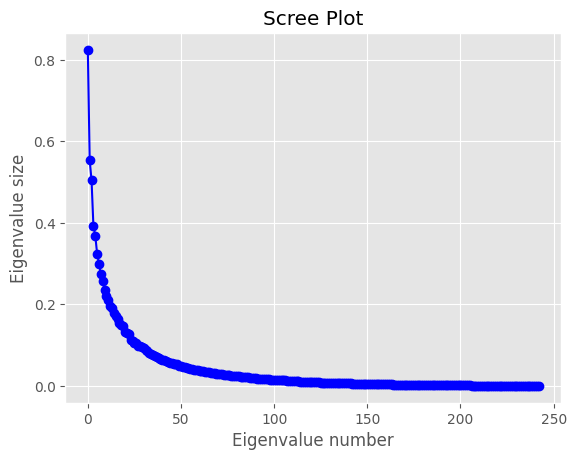

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(pooled_embeddings)

eigen_vals = pca.explained_variance_

import matplotlib.pyplot as plt
plt.style.use("ggplot")


plt.plot(eigen_vals, marker='o', color='blue')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")


Second one is cumulative explained variance plot. Reference: same as for scree

Dimensions to keep 90% variance: 62


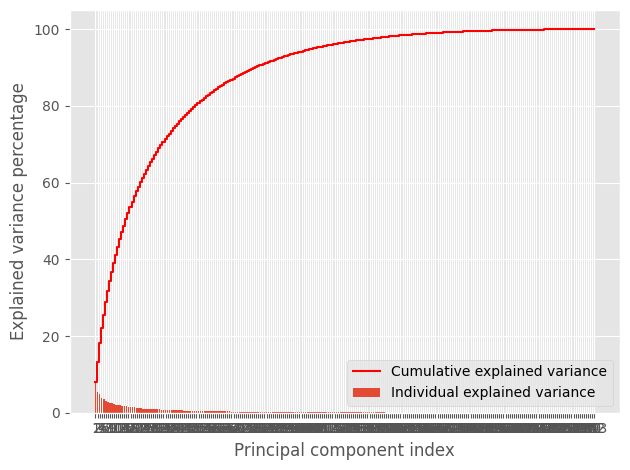

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(pooled_embeddings)

exp_var = pca.explained_variance_ratio_  * 100
cum_exp_var = np.cumsum(exp_var)

a = 244

plt.bar(range(1, a), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, a), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, a)))
plt.legend(loc='best')
plt.tight_layout()

nc = np.argmax(cum_exp_var >= 85) + 1
print(f"Dimensions to keep 90% variance: {nc}")

From the scree plot i see, that elbow is at nearly 30, and about 50 it is becoming more and more horizontal, which means minimum increases that can be reducted, In cummulative plot I need 79 features to retain 90% percent variance.\
To combine this info i decided to take 60 features. It keeps the varience between 84% and 85% and also is closer to observations on scree

## Part 5.  Reduce an output of LLM using information retrieved from embeddings

Size reduced from 384 to 60

In [ ]:
pca_reduced = PCA(n_components=60)
reduced_embeddings = pca_reduced.fit_transform(pooled_embeddings)

print("Shape of one:", reduced_embeddings[0].shape)
print("Shape of array:", reduced_embeddings.shape)

Shape of one: (60,)
Shape of array: (243, 60)


## Step 6. Create a search query. Conduct similarity search for created query. Analyze 10 closest results

In [ ]:
!pip install python-Levenshtein


In [ ]:
!pip install tabulate


I calculated cosine similarity and ranked the lines based on that. The additional column is Levenstein distance, which looks unsorted because of the previous criteria. The search string is taken from embeddings by index, also it is tracked that it will not find matches with itself

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import Levenshtein as lev
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

def perform_similarity_search(embeddings, query_index, text_data):
    search_query = embeddings[query_index].reshape(1, -1)
    print(f"Search Query: {text_data[query_index]}\n")

    cosine_similarities = cosine_similarity(search_query, embeddings).flatten()
    cosine_similarities[query_index] = -1
    top_10_indices = np.argsort(cosine_similarities)[-10:][::-1]
    top_10_strings = [text_data[i] for i in top_10_indices]

    levenshtein_distances = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            if i != j:
                levenshtein_distances[i, j] = lev.distance(top_10_strings[i], top_10_strings[j])

    top_10_distances = [lev.distance(text_data[query_index], top_10_strings[i]) for i in range(10)]

    results_df = pd.DataFrame({
        "Index": top_10_indices,
        "Distance": top_10_distances,
        "String": top_10_strings,

    })

    return results_df, top_10_indices

query_index = 1

print("Original Embeddings Results:")
original_results, original_top_10_indices = perform_similarity_search(pooled_embeddings, query_index, tokenized_text)
print(tabulate(original_results, headers="keys", tablefmt="grid"))

print("\nReduced Embeddings Results:")
reduced_results, reduced_top_10_indices = perform_similarity_search(reduced_embeddings, query_index, tokenized_text)
print(tabulate(reduced_results, headers="keys", tablefmt="grid"))


Original Embeddings Results:
Search Query: However, their ability to access and precisely manipulate knowledge is still limited, and hence on knowledge-intensive tasks, their performance lags behind task-specific architectures.

+----+---------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   Index |   Distance | String                                                                                                                                                                                                                                                                                       |
+====+=========+============+============================================================================================================

Here the differences between models are presented, in the table it can bee seen which numbers are present. Also the indexes that correspond fully by places, not only by presence, are listed


Results:
     In_High_Dim_Embeddings  In_Low_Dim_Embeddings
7                         1                      0
10                        1                      1
27                        1                      1
28                        0                      1
29                        1                      1
30                        1                      1
207                       0                      1
209                       1                      1
210                       1                      1
214                       1                      0
217                       1                      1
225                       1                      0
238                       0                      1


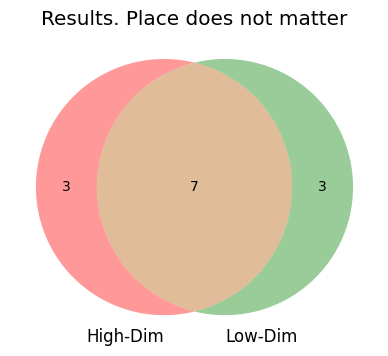


Indexes of intersections considering places of cosine similarity:
217 10 27 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

evaluation_df = pd.DataFrame({
    "In_High_Dim_Embeddings": [1 if i in original_top_10_indices else 0 for i in range(max(max(original_top_10_indices), max(reduced_top_10_indices)) + 1)],
    "In_Low_Dim_Embeddings": [1 if i in reduced_top_10_indices else 0 for i in range(max(max(original_top_10_indices), max(reduced_top_10_indices)) + 1)]
})

evaluation_df = evaluation_df[(evaluation_df["In_High_Dim_Embeddings"] == 1) | (evaluation_df["In_Low_Dim_Embeddings"] == 1)]

print("\nResults:")
print(evaluation_df)

high_dim_set = set(original_top_10_indices)
low_dim_set = set(reduced_top_10_indices)

plt.figure(figsize=(6, 4))
venn_diagram = venn2([high_dim_set, low_dim_set], ('High-Dim', 'Low-Dim'))
plt.title("Results. Place does not matter")
plt.show()


def find_place_based_intersection(original_indices, reduced_indices):
    intersection_indices = []
    for i in range(min(len(original_indices), len(reduced_indices))):
        if original_indices[i] == reduced_indices[i]:
            intersection_indices.append(original_indices[i])

    return intersection_indices
place_based_intersection_indices= find_place_based_intersection(original_top_10_indices, reduced_top_10_indices)

print("\nIndexes of intersections considering places of cosine similarity:")
for index in place_based_intersection_indices:
    print(index, end = " ")
